In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")


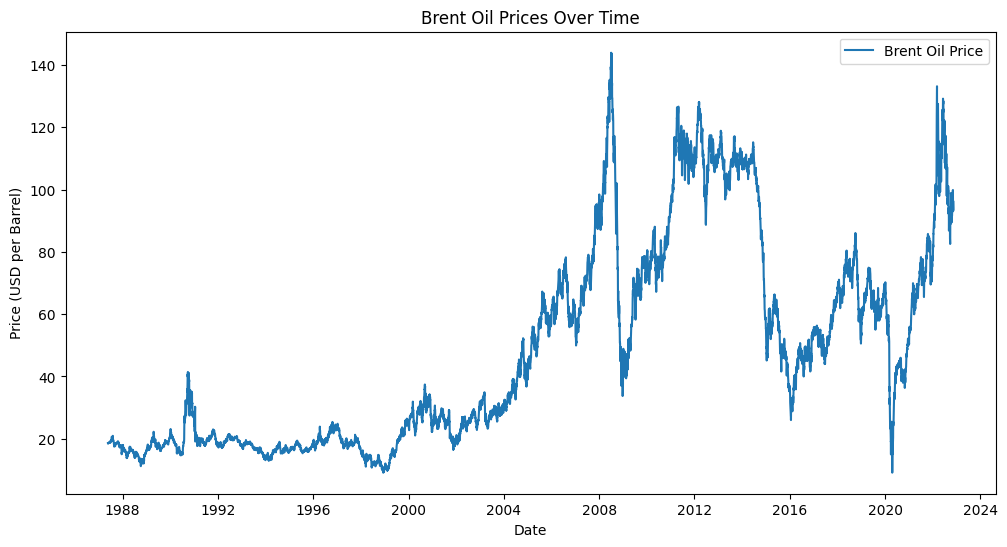

In [3]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Ensure 'Price' column is float
df['Price'] = df['Price'].astype(float)

# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.show()


### Vector Autoregression (VAR) Model for Multivariate Analysis

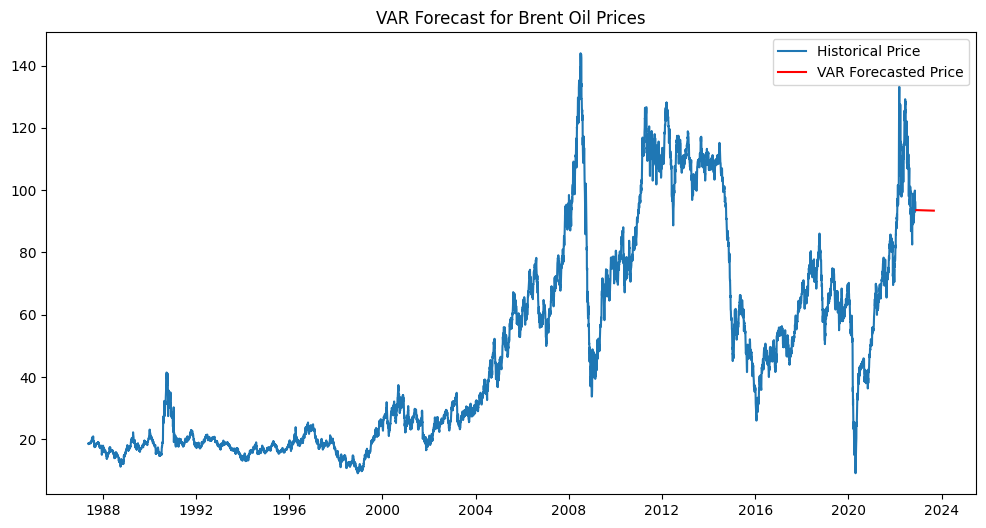

In [4]:
# Mock additional factors data
np.random.seed(42)
df['GDP'] = np.random.normal(loc=2.0, scale=0.5, size=len(df))  # hypothetical GDP growth rate
df['Inflation'] = np.random.normal(loc=1.5, scale=0.2, size=len(df))  # hypothetical inflation rate
df['Unemployment'] = np.random.normal(loc=5.0, scale=1.0, size=len(df))  # hypothetical unemployment rate

# Select relevant columns for VAR
var_data = df[['Price', 'GDP', 'Inflation', 'Unemployment']]
model = VAR(var_data)
var_result = model.fit(maxlags=15, ic='aic')

# Forecasting with VAR
forecast = var_result.forecast(var_data.values[-var_result.k_ar:], steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(df.index[-1], periods=10, freq='M'), columns=var_data.columns)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_df['Price'], label='VAR Forecasted Price', color='red')
plt.title('VAR Forecast for Brent Oil Prices')
plt.legend()
plt.show()


### Markov-Switching ARIMA for Regime-Switching

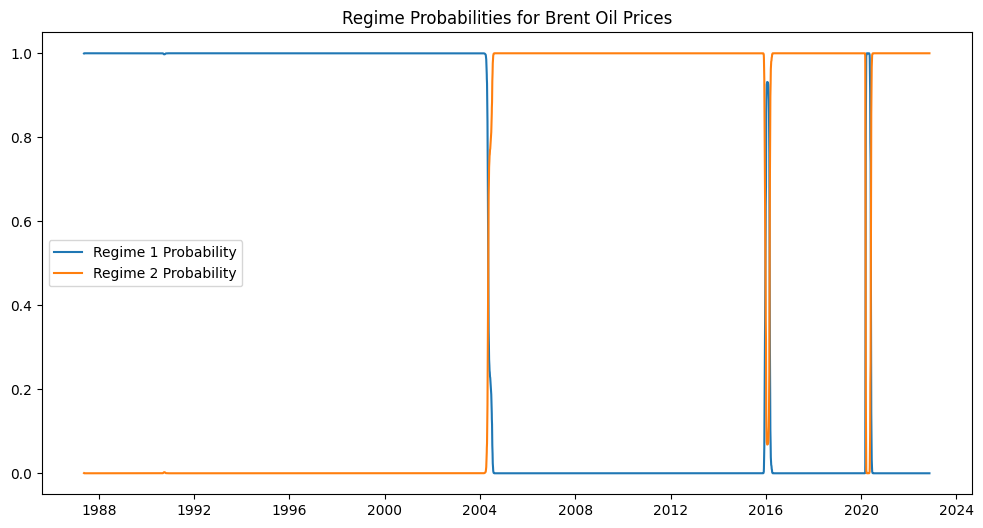

In [5]:
# Fit a Markov Switching Model on Brent Oil Prices
markov_model = MarkovRegression(df['Price'], k_regimes=2, trend='n', switching_variance=True)
markov_result = markov_model.fit()

# Plotting the Regime-Switching probabilities
plt.figure(figsize=(12, 6))
plt.plot(markov_result.smoothed_marginal_probabilities[0], label='Regime 1 Probability')
plt.plot(markov_result.smoothed_marginal_probabilities[1], label='Regime 2 Probability')
plt.title('Regime Probabilities for Brent Oil Prices')
plt.legend()
plt.show()


### LSTM Model for Time Series Forecasting

Epoch 1/20
8980/8980 - 36s - 4ms/step - loss: 3.4348e-04
Epoch 2/20
8980/8980 - 34s - 4ms/step - loss: 1.4851e-04
Epoch 3/20
8980/8980 - 34s - 4ms/step - loss: 1.4001e-04
Epoch 4/20
8980/8980 - 35s - 4ms/step - loss: 1.2622e-04
Epoch 5/20
8980/8980 - 35s - 4ms/step - loss: 1.2130e-04
Epoch 6/20
8980/8980 - 34s - 4ms/step - loss: 1.1843e-04
Epoch 7/20
8980/8980 - 35s - 4ms/step - loss: 1.1770e-04
Epoch 8/20
8980/8980 - 35s - 4ms/step - loss: 1.1541e-04
Epoch 9/20
8980/8980 - 35s - 4ms/step - loss: 1.1182e-04
Epoch 10/20
8980/8980 - 34s - 4ms/step - loss: 1.1160e-04
Epoch 11/20
8980/8980 - 34s - 4ms/step - loss: 1.1080e-04
Epoch 12/20
8980/8980 - 35s - 4ms/step - loss: 1.0915e-04
Epoch 13/20
8980/8980 - 36s - 4ms/step - loss: 1.0865e-04
Epoch 14/20
8980/8980 - 35s - 4ms/step - loss: 1.0604e-04
Epoch 15/20
8980/8980 - 36s - 4ms/step - loss: 1.0553e-04
Epoch 16/20
8980/8980 - 35s - 4ms/step - loss: 1.0709e-04
Epoch 17/20
8980/8980 - 34s - 4ms/step - loss: 1.0628e-04
Epoch 18/20
8980/8980 -

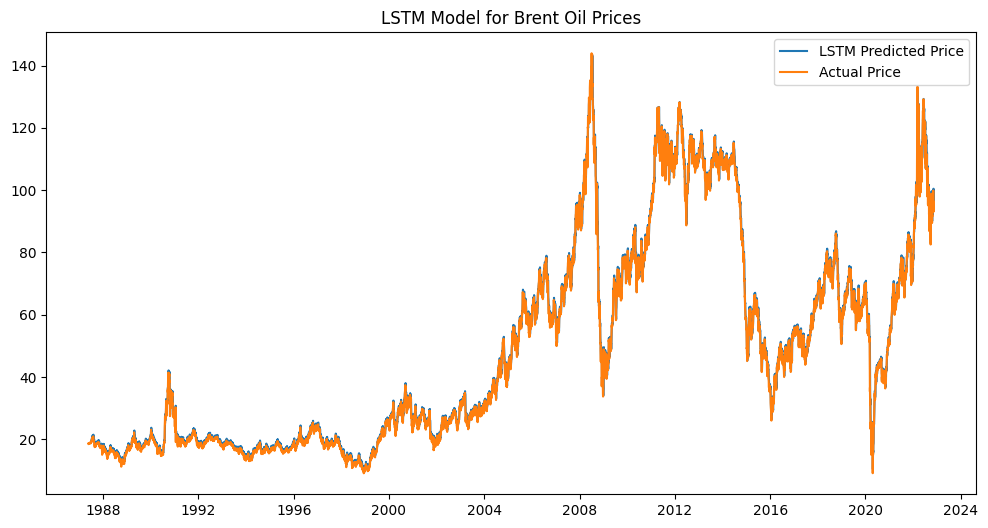

In [6]:
# Normalize the Price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Price']])

# Prepare the dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=1, verbose=2)

# Predict using LSTM
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plotting LSTM results
plt.figure(figsize=(12, 6))
plt.plot(df.index[look_back + 1:], predictions, label='LSTM Predicted Price')
plt.plot(df['Price'], label='Actual Price')
plt.title('LSTM Model for Brent Oil Prices')
plt.legend()
plt.show()


### Exploring Economic, Technological, and Political Factors

In [7]:
# Calculate correlation
gdp_corr = df['Price'].corr(df['GDP'])
print(f"Correlation between GDP growth rate and oil prices: {gdp_corr}")


Correlation between GDP growth rate and oil prices: -0.01865756425503499


In [8]:
inflation_corr = df['Price'].corr(df['Inflation'])
print(f"Correlation between inflation rate and oil prices: {inflation_corr}")


Correlation between inflation rate and oil prices: 0.007940614155305694


In [9]:
# Hypothetically adding data and analyzing correlation with price
df['Environmental_Regulations'] = np.random.normal(loc=2.0, scale=0.5, size=len(df))
env_reg_corr = df['Price'].corr(df['Environmental_Regulations'])
print(f"Correlation between environmental regulations index and oil prices: {env_reg_corr}")


Correlation between environmental regulations index and oil prices: 0.009733244818864104
